In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [476]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import set_matplotlib_formats
%matplotlib inline

In [477]:
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

In [478]:
default_color = '#56B4E9'
colormap = plt.cm.cool

In [479]:
def clean_tags(tags: str):
    tag_cleaned = tags.replace("[","").replace("]", "").replace("'","")
    tag_cleaned=re.sub(r"\s+", "", tag_cleaned)
    tag_cleaned = tag_cleaned.split(',')
    return tag_cleaned

In [480]:
df = pd.read_csv("../data/list_of_pocket_items_processed.csv", sep=';')

In [481]:
df.shape[0]

1942

In [482]:
df['tags'] = df['tags'].apply(lambda x : clean_tags(x))

In [483]:
df.explode('tags').shape[0] != df.shape[0]

True

In [432]:
df.dtypes

item_id             int64
resolved_id         int64
given_url          object
given_title        object
resolved_url       object
resolved_title     object
is_article          int64
excerpt            object
word_count          int64
lang               object
domain_metadata    object
tags               object
dtype: object

In [433]:
df.explode('tags').groupby('tags')['item_id'].count().sort_values(ascending=False)[:25]

tags
datascience        370
python             302
machinelearning    274
dataviz            267
nlp                115
gis                 92
deeplearning        74
statistics          64
blogs               47
web                 44
dataengineering     44
geo                 38
ddj                 38
pandas              36
jupyter             36
government          33
design              32
javascript          31
git                 30
linux               26
database            25
d3.js               25
webscraping         23
data                21
docker              21
Name: item_id, dtype: int64

In [377]:
df.head(2)

,item_id,resolved_id,given_url,given_title,resolved_url,resolved_title,is_article,excerpt,word_count,lang,domain_metadata,tags
0,2632654076,2632654076,https://ai.facebook.com/blog/open-sourcing-pyr...,NaN,https://ai.facebook.com/blog/open-sourcing-pyr...,Open-sourcing PyRobot to accelerate AI robotic...,1,Frameworks such as PyTorch have dramatically a...,1076,en,NaN,[ai]
1,2325959987,2325959987,https://ethicstoolkit.ai/,NaN,http://ethicstoolkit.ai/,Ethics & Algorithms Toolkit,0,Government leaders and staff who leverage algo...,103,en,NaN,[ai]


In [434]:
df['item_id'].nunique(), df['resolved_id'].nunique()

(1942, 1920)

### Pelo que está descrito na url https://getpocket.com/developer/docs/v3/retrieve

`resolved_id` - A unique identifier similar to the item_id but is unique to the actual url of the saved item. The resolved_id identifies unique urls. For example a direct link to a New York Times article and a link that redirects (ex a shortened bit.ly url) to the same article will share the same resolved_id. If this value is 0, it means that Pocket has not processed the item. Normally this happens within seconds but is possible you may request the item before it has been resolved.

#### Portanto, iremos usar como chave primária o campo `resolved_id`.

In [484]:
df.drop_duplicates('resolved_id', inplace=True)

In [485]:
df['item_id'].nunique(), df['resolved_id'].nunique()

(1920, 1920)

In [486]:
count_tags = Counter()

In [487]:
for count in df.explode('tags').groupby('resolved_id')['tags'].count().sort_values(ascending=True).values:
    count_tags[count] += 1

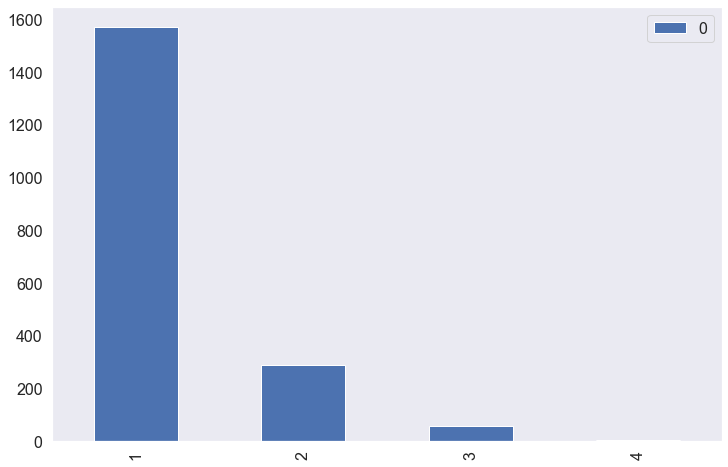

In [488]:
pd.DataFrame.from_dict(count_tags, orient='index').plot(kind='bar');

### Pelo gráfico acima é perceptível que a grande maioria das ocorrências é um artigo ter uma única tag associada.

##### A ideia é utilizar o mínimo possível de informação para inferir a tag mais apropriada. Dessa forma iremos utilizar apenas as features: `resolved_title` e `excerpt`.

In [489]:
df_filtered = df[['resolved_id', 'resolved_title', 'excerpt', 'tags']].copy()
df_filtered.reset_index(inplace=True)
del df_filtered['index']

In [490]:
df_filtered.explode('tags').groupby('tags')['resolved_id'].count().sort_values(ascending=False)[:20]

tags
datascience        369
python             299
machinelearning    269
dataviz            259
nlp                113
gis                 92
deeplearning        74
statistics          63
blogs               47
web                 44
dataengineering     44
geo                 38
pandas              36
ddj                 36
jupyter             36
government          33
design              32
javascript          31
git                 29
linux               26
Name: resolved_id, dtype: int64

In [491]:
#build a data structure for cumulative tags frequency
count_tags = pd.DataFrame(df_filtered.explode('tags').groupby('tags')['resolved_id'].count().sort_values(ascending=False).copy())
count_tags.columns = ['quantitativo']
count_tags['cumulative_sum'] = count_tags['quantitativo'].cumsum()
count_tags['cumulative_perc'] = 100*count_tags.cumulative_sum/count_tags['quantitativo'].sum()
count_select = count_tags[count_tags['cumulative_perc'] <= 95].copy()

In [492]:
count_tags[:20]

,quantitativo,cumulative_sum,cumulative_perc
tags,,,
datascience,369,369,15.80
python,299,668,28.60
machinelearning,269,937,40.11
dataviz,259,1196,51.20
nlp,113,1309,56.04
gis,92,1401,59.97
deeplearning,74,1475,63.14
statistics,63,1538,65.84
blogs,47,1585,67.85


In [493]:
print(f"Em relação aos artigos coletados do pocket temos um total de {count_tags.index.nunique()} tags distintas utilizadas.")
print(f"Todavia, ao todo {len(count_select.index)} tags representam 95% das ocorrências.")

Em relação aos artigos coletados do pocket temos um total de 51 tags distintas utilizadas.
Todavia, ao todo 35 tags representam 95% das ocorrências.


### Para fins de prova de conceito iremos trabalhar com o TOP 20 tags mais frequentes, que representam aproximadamente 84% das ocorrências.

In [494]:
tags_to_model = list(df_filtered.explode('tags').groupby('tags')['resolved_id'].count().sort_values(ascending=False)[:20].index)

In [495]:
df_filtered = df_filtered.sample(frac=1)
df_filtered = df.explode('tags')

In [496]:
df_filtered.head()

,item_id,resolved_id,given_url,given_title,resolved_url,resolved_title,is_article,excerpt,word_count,lang,domain_metadata,tags
0,2632654076,2632654076,https://ai.facebook.com/blog/open-sourcing-pyr...,NaN,https://ai.facebook.com/blog/open-sourcing-pyr...,Open-sourcing PyRobot to accelerate AI robotic...,1,Frameworks such as PyTorch have dramatically a...,1076,en,NaN,ai
1,2325959987,2325959987,https://ethicstoolkit.ai/,NaN,http://ethicstoolkit.ai/,Ethics & Algorithms Toolkit,0,Government leaders and staff who leverage algo...,103,en,NaN,ai
2,2592864641,2592797845,https://www.nytimes.com/2019/05/14/us/facial-r...,NaN,https://www.nytimes.com/2019/05/14/us/facial-r...,San Francisco Bans Facial Recognition Technology,1,"SAN FRANCISCO — San Francisco, long at the hea...",1757,en,The New York Times,ai
3,2539825098,2539825108,https://youtu.be/qIhb9uI4o5M,NaN,https://www.youtube.com/watch?v=qIhb9uI4o5M,Cadernos de IA - 1_1 - Agentes Inteligentes,0,Video Curso sobre Inteligência Artificial.Cade...,0,NaN,YouTube,ai
4,2480753055,2479824693,https://t.co/FzfX2q8PsL,NaN,https://www.nytimes.com/2019/02/05/technology/...,Making New Drugs With a Dose of Artificial Int...,1,SAN FRANCISCO — You can think of it as a World...,1176,en,The New York Times,ai


In [497]:
train_idxs = {}
for tag in tags_to_model:
    train_idxs[tag] = []
    select_data_tag = df_filtered[df_filtered['tags'] == tag].copy()
    size_of_tags = select_data_tag.shape[0]
    size_of_train = int(round(0.7*size_of_tags))
    print(f"Iniciando amostragem de {tag} {size_of_train} amostras.")
    sampled_tag = select_data_tag.sample(size_of_train)
    list_of_id = sampled_tag['resolved_id'].unique().tolist()
    list_of_idxs_to_drop = sampled_tag.index.tolist()
    train_idxs[tag].extend(list_of_id)
    data_train = df_filtered.drop(list_of_idxs_to_drop)

Iniciando amostragem de datascience 258 amostras.
Iniciando amostragem de python 209 amostras.
Iniciando amostragem de machinelearning 188 amostras.
Iniciando amostragem de dataviz 181 amostras.
Iniciando amostragem de nlp 79 amostras.
Iniciando amostragem de gis 64 amostras.
Iniciando amostragem de deeplearning 52 amostras.
Iniciando amostragem de statistics 44 amostras.
Iniciando amostragem de blogs 33 amostras.
Iniciando amostragem de web 31 amostras.
Iniciando amostragem de dataengineering 31 amostras.
Iniciando amostragem de geo 27 amostras.
Iniciando amostragem de pandas 25 amostras.
Iniciando amostragem de ddj 25 amostras.
Iniciando amostragem de jupyter 25 amostras.
Iniciando amostragem de government 23 amostras.
Iniciando amostragem de design 22 amostras.
Iniciando amostragem de javascript 22 amostras.
Iniciando amostragem de git 20 amostras.
Iniciando amostragem de linux 18 amostras.


In [498]:
all_new_ids = []
for tags in train_idxs.values():
    all_new_ids.extend(tags)

In [499]:
df_train = df.loc[df['resolved_id'].isin(all_new_ids)].copy()
df_train.drop_duplicates('resolved_id', inplace=True)

In [500]:
df_train.shape[0], df_train.index.nunique()

(1233, 1233)

In [501]:
df_test = df.loc[~df['resolved_id'].isin(df_train['resolved_id'].unique().tolist())].copy()
df_test.drop_duplicates('resolved_id', inplace=True)

In [502]:
df_train.shape[0], df_test.shape[0]

(1233, 687)

In [503]:
set(df_train.resolved_id.unique()).intersection(df_test.resolved_id.unique())

set()

In [504]:
df_train.explode('tags').groupby('tags')['item_id'].count().sort_values(ascending=False)[:20]

tags
datascience        289
python             235
machinelearning    201
dataviz            193
nlp                 82
gis                 68
deeplearning        60
statistics          48
blogs               36
web                 34
dataengineering     31
pandas              30
geo                 29
jupyter             27
ddj                 25
javascript          24
government          24
design              22
git                 20
linux               19
Name: item_id, dtype: int64

In [505]:
df_test.explode('tags').groupby('tags')['item_id'].count().sort_values(ascending=False)[:20]

tags
datascience        80
machinelearning    68
dataviz            66
python             64
nlp                31
gis                24
webscraping        23
d3.js              20
database           20
data               19
elasticsearch      17
docker             15
ai                 15
statistics         15
deeplearning       14
dataengineering    13
sql                12
spark              12
blogs              11
vscode             11
Name: item_id, dtype: int64

#### eliminar da base de treino e test as tags que estão fora do top 20

In [506]:
lista_all_tags = df.explode("tags")['tags'].unique()
tags_a_remover = list(set(lista_all_tags).difference(set(tags_to_model)))

In [507]:
df_train.reset_index(inplace=True)
del df_train['index']
df_test.reset_index(inplace=True)
del df_test['index']

In [508]:
df_train['tags_mod'] = ""

In [509]:
track_modify = {}
for index, row in df_train.iterrows():
    track_modify[index] = ""
    tags_original = row['tags'].copy()
    for tag_to_remove in tags_a_remover:
        if tag_to_remove in tags_original:
            tags_original.remove(tag_to_remove)
    track_modify[index] = tags_original
for index, tag in track_modify.items():
    df_train.at[index, 'tags_mod'] = tag

In [510]:
df_train['is_tag_modified'] = df_train.apply(lambda x : len(x['tags']) != len(x['tags_mod']), axis='columns')

In [511]:
df_train[df_train['is_tag_modified'] == True].shape[0]

84

In [512]:
df_test['tags_mod'] = ""

In [513]:
track_modify = {}
for index, row in df_test.iterrows():
    track_modify[index] = ""
    tags_original = row['tags'].copy()
    for tag_to_remove in tags_a_remover:
        if tag_to_remove in tags_original:
            tags_original.remove(tag_to_remove)
    track_modify[index] = tags_original
for index, tag in track_modify.items():
    df_test.at[index, 'tags_mod'] = tag

In [514]:
df_test['is_tag_modified'] = df_test.apply(lambda x : len(x['tags']) != len(x['tags_mod']), axis='columns')

In [515]:
df_test[df_test['is_tag_modified'] == True].shape[0]

273

In [516]:
df_test.explode('tags_mod').groupby('tags_mod')['resolved_id'].count().sort_values(ascending=False)

tags_mod
datascience        80
machinelearning    68
dataviz            66
python             64
nlp                31
gis                24
statistics         15
deeplearning       14
dataengineering    13
blogs              11
ddj                11
design             10
web                10
geo                 9
government          9
jupyter             9
git                 9
javascript          7
linux               7
pandas              6
Name: resolved_id, dtype: int64

In [526]:
#na exclusão das tags que não pertecem ao top 20 pode acontecer de algum artigo ficar sem nenhuma tag associada
df_test = df_test.drop(df_test[df_test['tags_mod'].apply(lambda x : len(x) == 0)].index)
df_train = df_train.drop(df_train[df_train['tags_mod'].apply(lambda x : len(x) == 0)].index)

In [527]:
df_train = df_train.loc[df_train['resolved_title'].dropna().index].copy()
df_test = df_test.loc[df_test['resolved_title'].dropna().index].copy()

In [528]:
df_train = df_train[['resolved_id', 'resolved_title', 'excerpt', 'tags_mod']].copy()
df_train.columns = ['resolved_id', 'resolved_title', 'excerpt', 'tags']

In [529]:
df_test = df_test[['resolved_id', 'resolved_title', 'excerpt', 'tags_mod']].copy()
df_test.columns = ['resolved_id', 'resolved_title', 'excerpt', 'tags']

In [531]:
df_train.shape[0], df_test.shape[0]

(1182, 438)

In [533]:
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [534]:
df_train.to_csv("../data/2019_11_14_train.csv", sep=';', index=False)
df_test.to_csv("../data/2019_11_14_test.csv", sep=';', index=False)